In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from collections import defaultdict
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

from bgspy.theory import bgs_rec, bgs_segment_sc16, bgs_segment
from bgspy.parallel import MapPosChunkIterator
from bgspy.classic import calc_B_SC16_chunk_worker
from bgspy.genome import Genome

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

In [4]:
bgs_segment_sc16(1e-8, 1e-5, 1000, 1e-4, 1000, full_output=True)

(array([101006.69930408,    999.9991813 ]),
 array({'nfev': 5, 'fjac': array([[-9.99999974e-01, -2.29243588e-04],
        [ 2.29243588e-04, -9.99999974e-01]]), 'r': array([ 9.90033240e-06, -9.80409052e-06,  1.00000268e-03]), 'qtf': array([ 6.92011542e-14, -3.34859137e-13]), 'fvec': array([1.77635684e-15, 8.88178420e-16])},
       dtype=object),
 array(1),
 array('The solution converged.', dtype='<U23'))

In [6]:
1.8e8 / 100000

1800.0

In [16]:
bgs_segment_sc16(1e-8, 1e-4, 1000, 1e-1, N=1000)**2000

0.9999810602791763

In [13]:
sh = np.logspace(-5, -1, 50)

In [18]:
mu = np.logspace(-9, -7, 3)[:, None, None]
sh = np.logspace(-5, -1, 4)[None, :, None]

sc16 = bgs_segment_sc16(mu, sh, [1000, 1000, 1000], [1e-8, 1e-8, 1e-8], 1000)

In [51]:
sc16.shape

(3, 4, 3)

In [ ]:
mu = np.logspace(-9, -7, 3)[:, None, None]
sh = np.logspace(-5, -1, 4)[None, :, None]

n = 100
L = np.random.randint(1, 100, n)
rbp = np.random.uniform(1e-9, 1e-7, n)



def manual_vectorization(mu, sh, L, rbp):
    B = defaultdict(list)
    for i in range(len(L)):
        for s in np.nditer(sh):
            for m in np.nditer(mu):
                b = bgs_segment_sc16(m, s, L[i], rbp[i], 1000)
                B[(float(m), float(s))].append(float(b))
    for key, val in B.items():
        B[key] = np.prod(np.array(val))
    return B
            

np.prod(bgs_segment_sc16(mu, sh, L, rbp, 1000), axis=2)

In [83]:
manual_vectorization(mu, sh, L, rbp)

defaultdict(list,
            {(1e-09, 1e-05): 0.9999995275214734,
             (1e-08, 1e-05): 0.9999952752257816,
             (1e-07, 1e-05): 0.9999527533439342,
             (1e-09, 0.00021544346900318823): 0.9998227361967416,
             (1e-08, 0.00021544346900318823): 0.9982288812972477,
             (1e-07, 0.00021544346900318823): 0.9824397265782665,
             (1e-09, 0.004641588833612777): 0.9989737276427394,
             (1e-08, 0.004641588833612777): 0.9897845698902533,
             (1e-07, 0.004641588833612777): 0.902418518629823,
             (1e-09, 0.1): 0.999952201911636,
             (1e-08, 0.1): 0.9995221219125683,
             (1e-07, 0.1): 0.9952314825838448})

In [71]:
from scipy.interpolate import interp2d

def interpolate_bgs_sc16(mu, sh, L, rbp, N):
    interpols = dict()
    nmu, nsh = len(mu), len(sh)
    for i, s in enumerate(np.nditer(sh)):
        for j, m in enumerate(np.nditer(mu)):
            z = bgs_segment_sc16(m, s, L, rbp[:, None], N)
            key = (float(m), float(s))
            #key = (i, j)
            interpols[key] = interp2d(L, rbp, z)
    def func(L, rbp):
        return np.array([interpol(L, rbp) for key, interpol in interpols.items()]).reshape(4, 3).T
    return func


mu = np.logspace(-9, -7, 3)
sh = np.logspace(-5, -1, 4)
L = np.linspace(1, 1000, 100).astype(int)
rf = np.logspace(-12, -7, 100)

In [72]:
sc16_interpol = interpolate_bgs_sc16(mu, sh, np.linspace(1, 1000, 100).astype(int), np.logspace(-12, -7, 11), N=1000)

In [73]:
%%timeit

sc16_interpol(1000, 1e-8)

147 µs ± 937 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [74]:
%%timeit

bgs_segment_sc16(mu, sh[:, None], 1000, 1e-8, N=1000)

2.02 ms ± 38.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [75]:
res_interpol = sc16_interpol(1000, 1e-8)
res_manual = bgs_segment_sc16(mu[:, None], sh, 1000, 1e-8, N=1000)
res_interpol, res_manual

(array([[0.9999999 , 0.99996286, 0.99978514, 0.99999   ],
        [0.99999901, 0.99962902, 0.99785356, 0.99990001],
        [0.9999901 , 0.99633012, 0.9787512 , 0.9990005 ]]),
 array([[0.9999999 , 0.99996286, 0.99978514, 0.99999   ],
        [0.99999901, 0.99962902, 0.99785356, 0.99990001],
        [0.9999901 , 0.99633012, 0.9787512 , 0.9990005 ]]))

In [36]:
sc16_interpol(1000, 1e-8)

array([[0.9999999 , 0.99999901, 0.9999901 , 0.99996286],
       [0.99962902, 0.99633012, 0.99978514, 0.99785356],
       [0.9787512 , 0.99999   , 0.99990001, 0.9990005 ]])

In [19]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
g.load_annot("../data/annotation/conserved_by_chrom/chr10.bed")
g.load_recmap("../data/annotation/hapmap/genetic_map_GRCh37_chr10.txt")
g.create_segments(split_length=10_000)
g
chunks = MapPosChunkIterator(g,  mu.squeeze(), sh.squeeze(), 1000, 5000)

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
completed segmenting chr10.
looking up map positions...	done.


In [20]:
chunk = next(chunks)

In [22]:
res = calc_B_SC16_chunk_worker(chunk)

/home/vsb/projects/bprime/bgspy/theory.py:50: RuntimeWarning: invalid value encountered in log
  return [np.log((np.exp(2*sh*Ne) - 1)/(2*U*sh*Ne)) - np.log(T),
/home/vsb/projects/bprime/bgspy/theory.py:56: UserWarning: no solution found!
  warnings.warn("no solution found!")


In [29]:
res[0].prod(axis=2)

array([[9.98018565e-01, 4.74764058e-01, 1.25745113e-02, 8.15027354e-01],
       [9.86206794e-01, 5.46737430e-03, 4.13402564e-14, 2.36296205e-01],
       [5.93488549e-01, 8.40677729e-80,            nan,            nan]])

In [30]:
np.exp(np.log(res[0]).sum(axis=2))

array([[9.98018565e-01, 4.74764058e-01, 1.25745113e-02, 8.15027354e-01],
       [9.86206794e-01, 5.46737430e-03, 4.13402564e-14, 2.36296205e-01],
       [5.93488549e-01, 8.40677729e-80,            nan,            nan]])

In [36]:
(res[0][1, 2, :]).shape

(6239,)

In [40]:
res[1][2, 2]

array([0.93238786, 0.9518603 ,        nan, ..., 0.99994065, 0.99997858,
       0.99986784])

(0.993, 1.002)

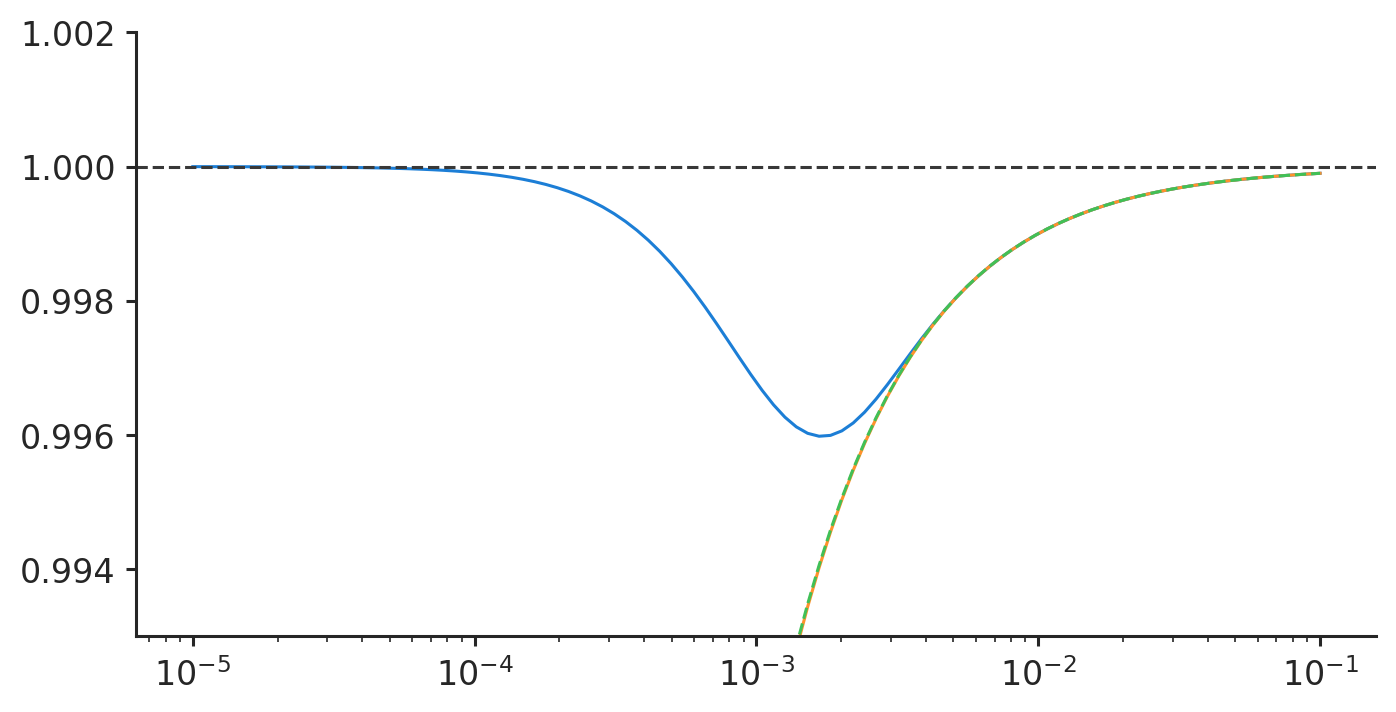

In [15]:
mu = 1e-8
rf = 0.001
rf = 1e-8
sh = np.logspace(-5, -1, 100)
L = 1000
N = 1000
sc16 = bgs_segment_sc16(mu, sh, L, rf, N)

plt.plot(sh, sc16)
plt.plot(sh, bgs_rec(mu, sh, L, rf))
plt.plot(sh, bgs_segment(mu, sh, L, 1e-8, rf), linestyle='dashed')
plt.semilogx()
plt.axhline(1, linestyle='dashed', c='0.22')
#plt.ylim(np.nanmin(sc16)*0.999, 1.0002)
plt.ylim(0.993, 1.002)